In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image

%matplotlib inline

/mnt/hdd2t/miniconda3/envs/UniverSeg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ================= CONFIG =================
DATA_ROOT = "/thiends/hdd2t/UniverSeg/OTU_2D"  # Adjust to your actual path, e.g., "/content/OTU_2D"
TRAIN_IMAGES = os.path.join(DATA_ROOT, "train1/Image/")
TRAIN_LABELS = os.path.join(DATA_ROOT, "train1/Label/")
VAL_IMAGES = os.path.join(DATA_ROOT, "validation1/Image/")
VAL_LABELS = os.path.join(DATA_ROOT, "validation1/Label/")
TRAIN_TXT = os.path.join(DATA_ROOT, "train.txt")
VAL_TXT = os.path.join(DATA_ROOT, "val.txt")
TRAIN_CLS = os.path.join(DATA_ROOT, "train_cls.txt")
VAL_CLS = os.path.join(DATA_ROOT, "val_cls.txt")
RESIZE_TO = (128, 128)
# =========================================

NUM_CLASSES = 8
LABEL_NAMES = [f"Class {i}" for i in range(NUM_CLASSES)]

# Load class labels
def load_cls_labels(filepath):
    labels = {}
    with open(filepath) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                filename = parts[0].replace('.JPG', '')
                cls = int(parts[1])
                labels[filename] = cls
    return labels

train_cls_labels = load_cls_labels(TRAIN_CLS)
val_cls_labels = load_cls_labels(VAL_CLS)

# ---------- Utils ----------
def process_image(image_path, resize_to):
    try:
        img = Image.open(image_path).convert("RGB")
        img = img.resize(resize_to, Image.BILINEAR)
        img = np.array(img, dtype=np.float32) / 255.0
        return np.transpose(img, (2, 0, 1))
    except Exception:
        return None

def process_mask(mask_path, resize_to):
    """
    Load mask và BINARY hóa: pixel > 0 → 1.0, pixel = 0 → 0.0
    UniverSeg yêu cầu mask binary (0 hoặc 1)
    """
    try:
        mask = Image.open(mask_path).convert('L')
        mask = mask.resize(resize_to, Image.NEAREST)
        mask = np.array(mask, dtype=np.float32)
        # QUAN TRỌNG: Binary hóa mask - bất kỳ pixel > 0 → 1.0
        mask = (mask > 0).astype(np.float32)
        return mask
    except Exception:
        return None

# === VERIFY MASK LOADING ===
print("🔍 Kiểm tra process_mask...")
test_mask_path = os.path.join(TRAIN_LABELS, os.listdir(TRAIN_LABELS)[0])
test_mask = process_mask(test_mask_path, RESIZE_TO)
print(f"   Mask path: {test_mask_path}")
print(f"   Mask unique values: {np.unique(test_mask)}")
print(f"   Mask shape: {test_mask.shape}")
if np.array_equal(np.unique(test_mask), [0., 1.]) or np.array_equal(np.unique(test_mask), [0.]) or np.array_equal(np.unique(test_mask), [1.]):
    print("   ✅ Mask đã được binary hóa đúng!")
else:
    print(f"   ❌ LỖI: Mask chưa binary! Values: {np.unique(test_mask)}")

# ---------- Dataset ----------
class OTU2DDataset:
    def __init__(self, images_dir, labels_dir, ids_file, cls_labels, resize_to=RESIZE_TO):
        self.samples = []
        self.cls_labels = cls_labels
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.resize_to = resize_to

        print("=" * 70)
        print(f"Loading OTU2DDataset for {os.path.basename(images_dir)}...")
        print("=" * 70)

        with open(ids_file, 'r') as f:
            ids = [line.strip() for line in f if line.strip()]

        for id_ in ids:
            img_name = f"{id_}.JPG"
            mask_name = f"{id_}.PNG"
            img_path = os.path.join(images_dir, img_name)
            mask_path = os.path.join(labels_dir, mask_name)

            if not os.path.exists(img_path) or not os.path.exists(mask_path):
                continue

            cls = self.cls_labels.get(id_, None)
            if cls is None:
                continue

            img = process_image(img_path, resize_to)
            if img is None:
                continue

            mask = process_mask(mask_path, resize_to)
            if mask is None:
                continue

            if np.sum(mask) < 1:  # Skip if no significant mask
                continue

            masks = np.zeros((NUM_CLASSES, resize_to[1], resize_to[0]), dtype=np.float32)
            masks[cls] = mask

            self.samples.append((img, masks, img_path))

        print(f"Loaded {len(self.samples)} valid samples.")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img, masks, img_path = self.samples[idx]
        return (
            torch.from_numpy(img).float(),
            torch.from_numpy(masks).float(),
            img_path
        )

🔍 Kiểm tra process_mask...
   Mask path: /thiends/hdd2t/UniverSeg/OTU_2D/train1/Label/1279.PNG
   Mask unique values: [0. 1.]
   Mask shape: (128, 128)
   ✅ Mask đã được binary hóa đúng!


In [3]:
support_pool = OTU2DDataset(TRAIN_IMAGES, TRAIN_LABELS, TRAIN_TXT, train_cls_labels)
test_set = OTU2DDataset(VAL_IMAGES, VAL_LABELS, VAL_TXT, val_cls_labels)
print(f"\nTổng số ảnh có annotation trong support: {len(support_pool)}")
print(f"Tổng số ảnh có annotation trong test: {len(test_set)}")

Loading OTU2DDataset for ...
Loaded 1000 valid samples.
Loading OTU2DDataset for ...
Loaded 469 valid samples.

Tổng số ảnh có annotation trong support: 1000
Tổng số ảnh có annotation trong test: 469


In [4]:
label_counts = defaultdict(int)
label_indices = defaultdict(list)

# Kết hợp support + test để tính toàn bộ
combined_dataset = support_pool.samples + test_set.samples

for idx in range(len(combined_dataset)):
    _, masks, _ = combined_dataset[idx]
    for label_idx in range(NUM_CLASSES):
        if np.sum(masks[label_idx]) > 1:  # Có vùng đáng kể
            label_counts[label_idx] += 1
            label_indices[label_idx].append(idx)

print("[INFO] Phân bố nhãn trong toàn bộ dataset:")
for label_idx in range(NUM_CLASSES):
    name = LABEL_NAMES[label_idx]
    count = label_counts[label_idx]
    pct = 100 * count / len(combined_dataset) if len(combined_dataset) > 0 else 0
    if count >= 100:
        status = "✅ COMMON"
    elif count >= 50:
        status = "✓ MEDIUM"
    elif count >= 20:
        status = "⚠️ RARE"
    else:
        status = "❌ VERY RARE"
    print(f"  [{label_idx}] {name:20s}: {count:3d} ảnh ({pct:5.1f}%) {status}")

[INFO] Phân bố nhãn trong toàn bộ dataset:
  [0] Class 0             : 336 ảnh ( 22.9%) ✅ COMMON
  [1] Class 1             : 219 ảnh ( 14.9%) ✅ COMMON
  [2] Class 2             : 336 ảnh ( 22.9%) ✅ COMMON
  [3] Class 3             :  88 ảnh (  6.0%) ✓ MEDIUM
  [4] Class 4             :  66 ảnh (  4.5%) ✓ MEDIUM
  [5] Class 5             : 267 ảnh ( 18.2%) ✅ COMMON
  [6] Class 6             : 104 ảnh (  7.1%) ✅ COMMON
  [7] Class 7             :  53 ảnh (  3.6%) ✓ MEDIUM



=== HIỂN THỊ 1 ẢNH ĐẦU TIÊN MỖI NHÃN: ORIGINAL vs GT CONTOUR (ĐƯỜNG VIỀN) ===


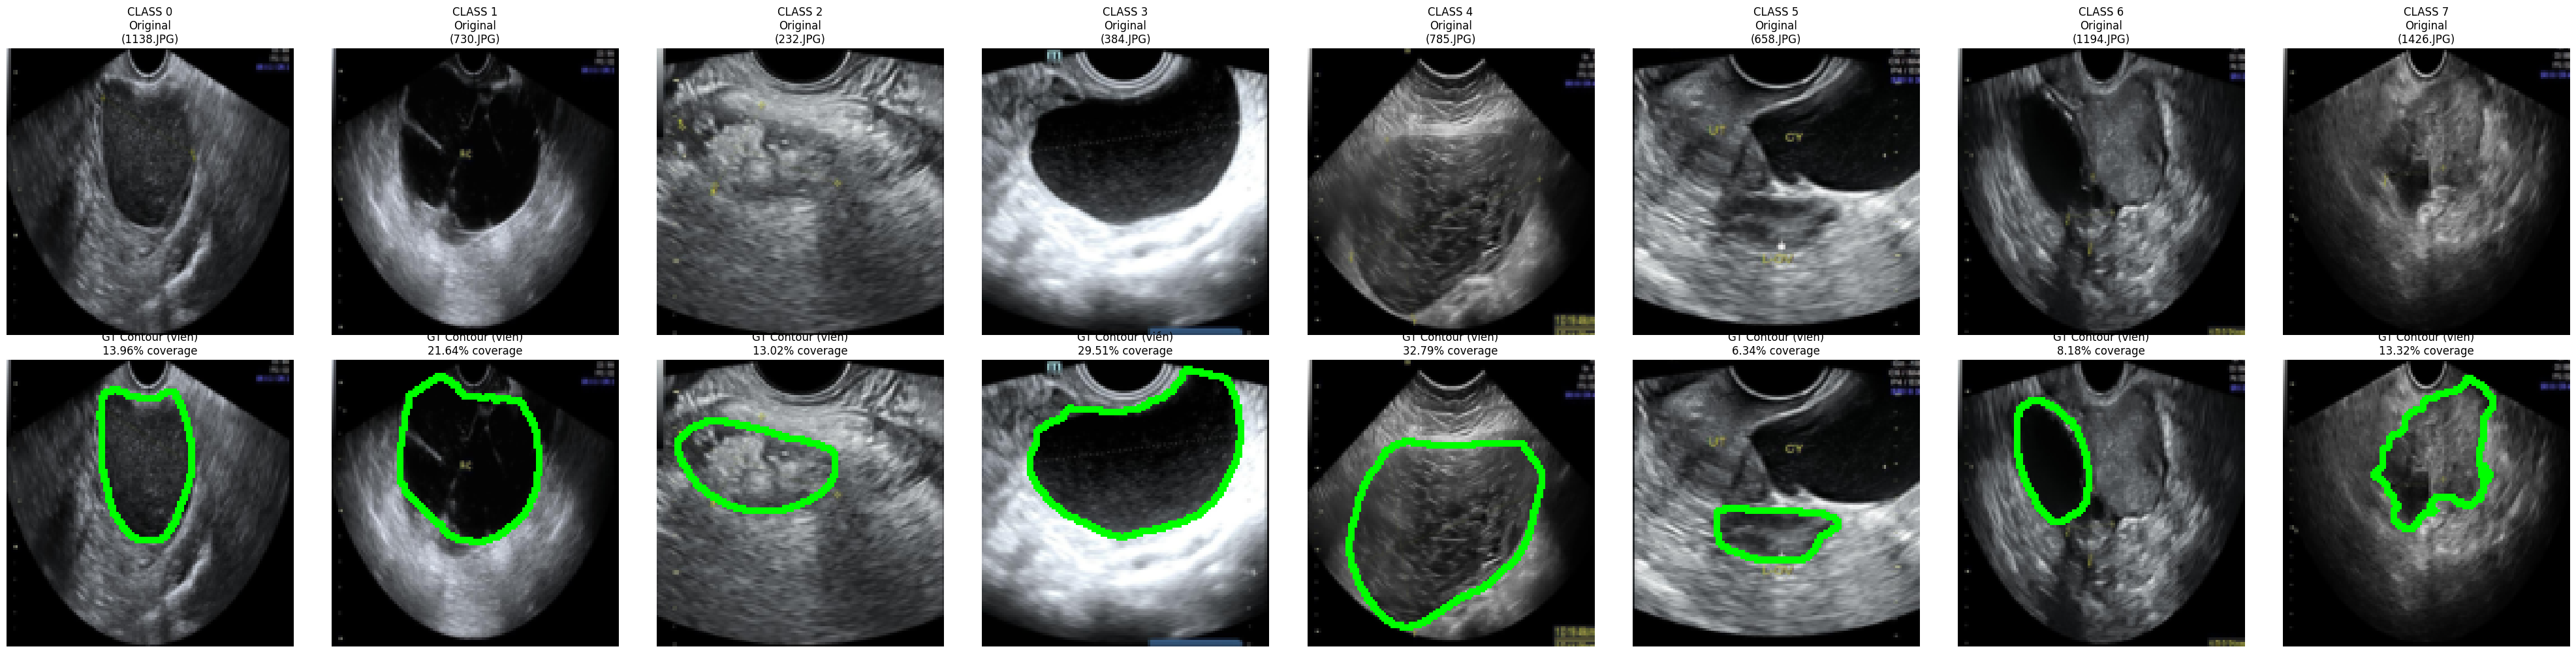

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import cv2  # OpenCV - thường đã có sẵn, không cần pip install trong Colab/Kaggle/Jupyter CV

def show_first_sample_with_gt_contour():
    print("\n=== HIỂN THỊ 1 ẢNH ĐẦU TIÊN MỖI NHÃN: ORIGINAL vs GT CONTOUR (ĐƯỜNG VIỀN) ===")

    # Lấy các nhãn có dữ liệu từ toàn bộ
    active_labels = [i for i in range(NUM_CLASSES) if len(label_indices[i]) > 0]

    if not active_labels:
        print("Không có nhãn nào có dữ liệu.")
        return

    num_cols = len(active_labels)
    fig, axes = plt.subplots(2, num_cols, figsize=(5 * num_cols, 10))

    # Xử lý trường hợp chỉ 1 nhãn
    if num_cols == 1:
        axes = axes[:, np.newaxis]

    for col_idx, label_idx in enumerate(active_labels):
        name = LABEL_NAMES[label_idx]
        indices = label_indices[label_idx]
        first_idx = indices[0]  # Ảnh đầu tiên có nhãn này

        img, masks, path = combined_dataset[first_idx]

        # Chuyển ảnh sang numpy RGB
        if isinstance(img, torch.Tensor):
            img_np = img.detach().cpu().numpy()
        else:
            img_np = img
        img_rgb = np.transpose(img_np, (1, 2, 0))
        img_rgb = np.clip(img_rgb, 0, 1)

        # Chuyển sang BGR uint8 để dùng OpenCV vẽ contour
        img_bgr = (img_rgb * 255).astype(np.uint8)[:, :, ::-1]  # RGB → BGR

        basename = os.path.basename(path)

        # Lấy mask nhị phân của nhãn hiện tại
        mask = masks[label_idx]
        if isinstance(mask, torch.Tensor):
            mask = mask.detach().cpu().numpy()
        mask_bin = (mask > 0).astype(np.uint8)  # 0 hoặc 1

        # Tính coverage
        coverage = 100.0 * np.sum(mask_bin) / mask_bin.size

        # Dùng OpenCV tìm contours (chỉ lấy contour ngoài cùng)
        contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Tạo bản sao để vẽ contour
        img_with_contour = img_bgr.copy()
        cv2.drawContours(img_with_contour, contours, -1, (0, 255, 0), thickness=2)  # Màu xanh lá, dày 3px

        # Chuyển lại RGB để hiển thị với matplotlib
        img_with_contour_rgb = img_with_contour[:, :, ::-1]

        # === HÀNG TRÊN: Original Image ===
        axes[0, col_idx].imshow(img_rgb)
        axes[0, col_idx].set_title(f"{name.upper()}\nOriginal\n({basename})", fontsize=12)
        axes[0, col_idx].axis('off')

        # === HÀNG DƯỚI: Ảnh + GT Contour ===
        axes[1, col_idx].imshow(img_with_contour_rgb)
        axes[1, col_idx].set_title(f"GT Contour (viền)\n{coverage:.2f}% coverage", fontsize=12)
        axes[1, col_idx].axis('off')

    plt.tight_layout()
    plt.show()

# ================== GỌI HÀM ==================
show_first_sample_with_gt_contour()

In [6]:
from collections import defaultdict

print("=== PHÂN BỐ NHÃN TRONG SUPPORT POOL ({}) ===\n".format(len(support_pool)))

label_counts_support = defaultdict(int)
label_indices_support = defaultdict(list)

for idx in range(len(support_pool)):
    _, masks, _ = support_pool[idx]  # masks: torch.Tensor shape [8, 128, 128]
    for label_idx in range(NUM_CLASSES):
        # SỬA TẠI ĐÂY: dùng .sum().item() của PyTorch thay vì np.sum
        if masks[label_idx].sum().item() > 1:  # Có vùng đáng kể (chỉ cần >1 pixel là đủ)
            label_counts_support[label_idx] += 1
            label_indices_support[label_idx].append(idx)

print(f"{'ID':<3} {'Tên nhãn':<25} {'Số ảnh':<6} {'Tỷ lệ':<8} Trạng thái")
print("-" * 60)

total_images = len(support_pool)
for label_idx in sorted(label_counts_support.keys()):
    name = LABEL_NAMES[label_idx]
    count = label_counts_support[label_idx]
    pct = 100 * count / total_images if total_images > 0 else 0

    if count >= 100:
        status = "✅ COMMON"
    elif count >= 60:
        status = "✓ MEDIUM"
    elif count >= 30:
        status = "⚠️ RARE"
    else:
        status = "❌ VERY RARE"

    print(f"{label_idx:<3} {name:<25} {count:<6} {pct:5.1f}%   {status}")

# In thêm cảnh báo nếu có class quá hiếm
very_rare = [LABEL_NAMES[i] for i, c in label_counts_support.items() if c < 20]
if very_rare:
    print(f"\n⚠️  CẢNH BÁO: Các class VERY RARE trong support pool: {', '.join(very_rare)}")
    print("   → Có thể ảnh hưởng nhẹ đến performance few-shot trên các class này.")
else:
    print("\n✅ Tất cả các class đều có đủ ví dụ trong support pool.")

=== PHÂN BỐ NHÃN TRONG SUPPORT POOL (1000) ===

ID  Tên nhãn                  Số ảnh Tỷ lệ    Trạng thái
------------------------------------------------------------
0   Class 0                   226     22.6%   ✅ COMMON
1   Class 1                   153     15.3%   ✅ COMMON
2   Class 2                   228     22.8%   ✅ COMMON
3   Class 3                   57       5.7%   ⚠️ RARE
4   Class 4                   47       4.7%   ⚠️ RARE
5   Class 5                   180     18.0%   ✅ COMMON
6   Class 6                   71       7.1%   ✓ MEDIUM
7   Class 7                   38       3.8%   ⚠️ RARE

✅ Tất cả các class đều có đủ ví dụ trong support pool.


In [14]:
# ================== DEBUG CELL - TEST NHIỀU SUPPORT ==================
print("=" * 70)
print("DEBUG: Kiểm tra ảnh hưởng của số lượng support images")
print("=" * 70)

# 1. Kiểm tra mask đã binary chưa
print("\n[1] KIỂM TRA MASK BINARY:")
sample_img, sample_masks, sample_path = support_pool[0]
print(f"    Masks unique values: {torch.unique(sample_masks)}")
if torch.equal(torch.unique(sample_masks[sample_masks > 0]), torch.tensor([1.0])):
    print("    ✅ Mask đã binary đúng!")
else:
    print("    ❌ Mask chưa binary!")

# 2. Tìm một cặp query-support tốt
print("\n[2] TÌM ẢNH TEST CÓ MASK RÕ RÀNG:")
query_img = query_gt = img_path = cls_idx = None
for idx in range(min(50, len(test_set))):
    q_img, q_gt, q_path = test_set[idx]
    for c in range(NUM_CLASSES):
        mask_sum = q_gt[c].sum().item()
        if mask_sum > 500:  # Mask đủ lớn
            query_img, query_gt, img_path, cls_idx = q_img, q_gt, q_path, c
            print(f"    Found: idx={idx}, class={c}, mask_sum={mask_sum:.0f}")
            break
    if query_img is not None:
        break

if query_img is None:
    print("    ❌ Không tìm thấy ảnh phù hợp!")
else:
    # 3. Test với số lượng support khác nhau
    print("\n[3] TEST DICE VỚI SỐ LƯỢNG SUPPORT KHÁC NHAU:")
    print(f"    Target class: {cls_idx}, Available supports: {len(label_indices_support[cls_idx])}")
    
    N_tests = [1, 2, 4, 8, 16, 32]
    
    query_gray = query_img.mean(dim=0, keepdim=True).unsqueeze(0).to(DEVICE)
    gt = query_gt[cls_idx].to(DEVICE)
    
    results = []
    for N in N_tests:
        # Lấy N support images
        target_pool = label_indices_support[cls_idx]
        K = min(N, len(target_pool))
        
        imgs = []
        masks = []
        for i in range(K):
            sup_idx = target_pool[i]
            sup_img, sup_masks, _ = support_pool[sup_idx]
            imgs.append(sup_img.mean(dim=0, keepdim=True))  # Grayscale
            masks.append(sup_masks[cls_idx].unsqueeze(0))
        
        support_imgs = torch.stack(imgs).unsqueeze(0).to(DEVICE)   # [1, K, 1, H, W]
        support_masks = torch.stack(masks).unsqueeze(0).to(DEVICE) # [1, K, 1, H, W]
        
        with torch.no_grad():
            output = model(query_gray, support_imgs, support_masks)
            pred = torch.sigmoid(output[0, 0])
        
        # Tính Dice
        pred_bin = (pred > 0.5).float()
        intersection = (pred_bin * gt).sum()
        union = pred_bin.sum() + gt.sum()
        dice = (2. * intersection + 1e-6) / (union + 1e-6)
        
        results.append((N, K, dice.item(), pred.mean().item(), pred.max().item()))
        print(f"    N={N:2d} (actual K={K:2d}): Dice={dice.item():.4f}, pred_mean={pred.mean().item():.4f}, pred_max={pred.max().item():.4f}")
    
    # 4. Visualize so sánh N=1 vs N=32
    print("\n[4] VISUALIZE: N=1 vs N=32")
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    for row, N in enumerate([1, 32]):
        target_pool = label_indices_support[cls_idx]
        K = min(N, len(target_pool))
        
        imgs = [support_pool[target_pool[i]][0].mean(dim=0, keepdim=True) for i in range(K)]
        masks = [support_pool[target_pool[i]][1][cls_idx].unsqueeze(0) for i in range(K)]
        
        support_imgs = torch.stack(imgs).unsqueeze(0).to(DEVICE)
        support_masks = torch.stack(masks).unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            pred = torch.sigmoid(model(query_gray, support_imgs, support_masks)[0, 0])
        
        pred_bin = (pred > 0.5).float()
        intersection = (pred_bin * gt).sum()
        union = pred_bin.sum() + gt.sum()
        dice = (2. * intersection + 1e-6) / (union + 1e-6)
        
        # Query image
        axes[row, 0].imshow(query_img.permute(1, 2, 0).numpy())
        axes[row, 0].set_title(f"Query Image (N={N})")
        axes[row, 0].axis('off')
        
        # Ground Truth
        axes[row, 1].imshow(gt.cpu().numpy(), cmap='gray')
        axes[row, 1].set_title(f"Ground Truth\nsum={gt.sum():.0f}")
        axes[row, 1].axis('off')
        
        # Prediction (heatmap)
        axes[row, 2].imshow(pred.cpu().numpy(), cmap='hot', vmin=0, vmax=1)
        axes[row, 2].set_title(f"Prediction (N={N})\nmax={pred.max():.3f}")
        axes[row, 2].axis('off')
        
        # Overlay
        overlay = query_img.permute(1, 2, 0).numpy().copy()
        pred_np = pred.cpu().numpy()
        axes[row, 3].imshow(overlay)
        axes[row, 3].imshow(pred_np > 0.5, alpha=0.5, cmap='Greens')
        axes[row, 3].contour(gt.cpu().numpy(), colors='red', linewidths=2)
        axes[row, 3].set_title(f"Overlay (Dice={dice.item():.3f})\nGreen=Pred, Red=GT")
        axes[row, 3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 5. Summary
    print("\n[5] NHẬN XÉT:")
    dice_n1 = results[0][2]
    dice_n32 = results[-1][2] if results[-1][0] == 32 else results[-2][2]
    
    if dice_n32 > 0.5:
        print(f"    ✅ Với N=32, Dice = {dice_n32:.3f} - Model hoạt động tốt!")
    elif dice_n32 > 0.3:
        print(f"    ⚠️  Với N=32, Dice = {dice_n32:.3f} - Trung bình, có thể cải thiện")
    else:
        print(f"    ❌ Với N=32, Dice = {dice_n32:.3f} - Vẫn thấp, cần kiểm tra thêm")
    
    if dice_n32 > dice_n1 * 2:
        print(f"    📈 Dice tăng {dice_n32/dice_n1:.1f}x khi tăng N từ 1 lên 32 - More support = Better!")

print("\n" + "=" * 70)

DEBUG: Kiểm tra ảnh hưởng của số lượng support images

[1] KIỂM TRA MASK BINARY:
    Masks unique values: tensor([0., 1.])
    ✅ Mask đã binary đúng!

[2] TÌM ẢNH TEST CÓ MASK RÕ RÀNG:
    Found: idx=0, class=5, mask_sum=1035

[3] TEST DICE VỚI SỐ LƯỢNG SUPPORT KHÁC NHAU:
    Target class: 5, Available supports: 180


NameError: name 'DEVICE' is not defined

In [13]:
import clip

Precomputing CLIP embeddings cho support_pool...
Đang tìm ảnh test có Dice cao nhất cho từng class (trong 100 ảnh đầu)...
  → Class 0                   : Best Dice = 0.980 | Ảnh: 580.JPG (idx=16)
  → Class 1                   : Best Dice = 0.985 | Ảnh: 249.JPG (idx=84)
  → Class 2                   : Best Dice = 0.960 | Ảnh: 1337.JPG (idx=6)
  → Class 3                   : Best Dice = 0.962 | Ảnh: 1181.JPG (idx=97)
  → Class 4                   : Best Dice = 0.958 | Ảnh: 1013.JPG (idx=34)
  → Class 5                   : Best Dice = 0.948 | Ảnh: 1269.JPG (idx=0)
  → Class 6                   : Best Dice = 0.967 | Ảnh: 896.JPG (idx=76)
  → Class 7                   : Best Dice = 0.925 | Ảnh: 1454.JPG (idx=23)

Đang chạy inference đầy đủ cho bảng 7x8 (mỗi class dùng ảnh riêng)...

HOÀN TẤT! Bảng đã lưu tại: UniverSeg_7x8_per_class_best_image_CLIP_MatchSeg_style.png


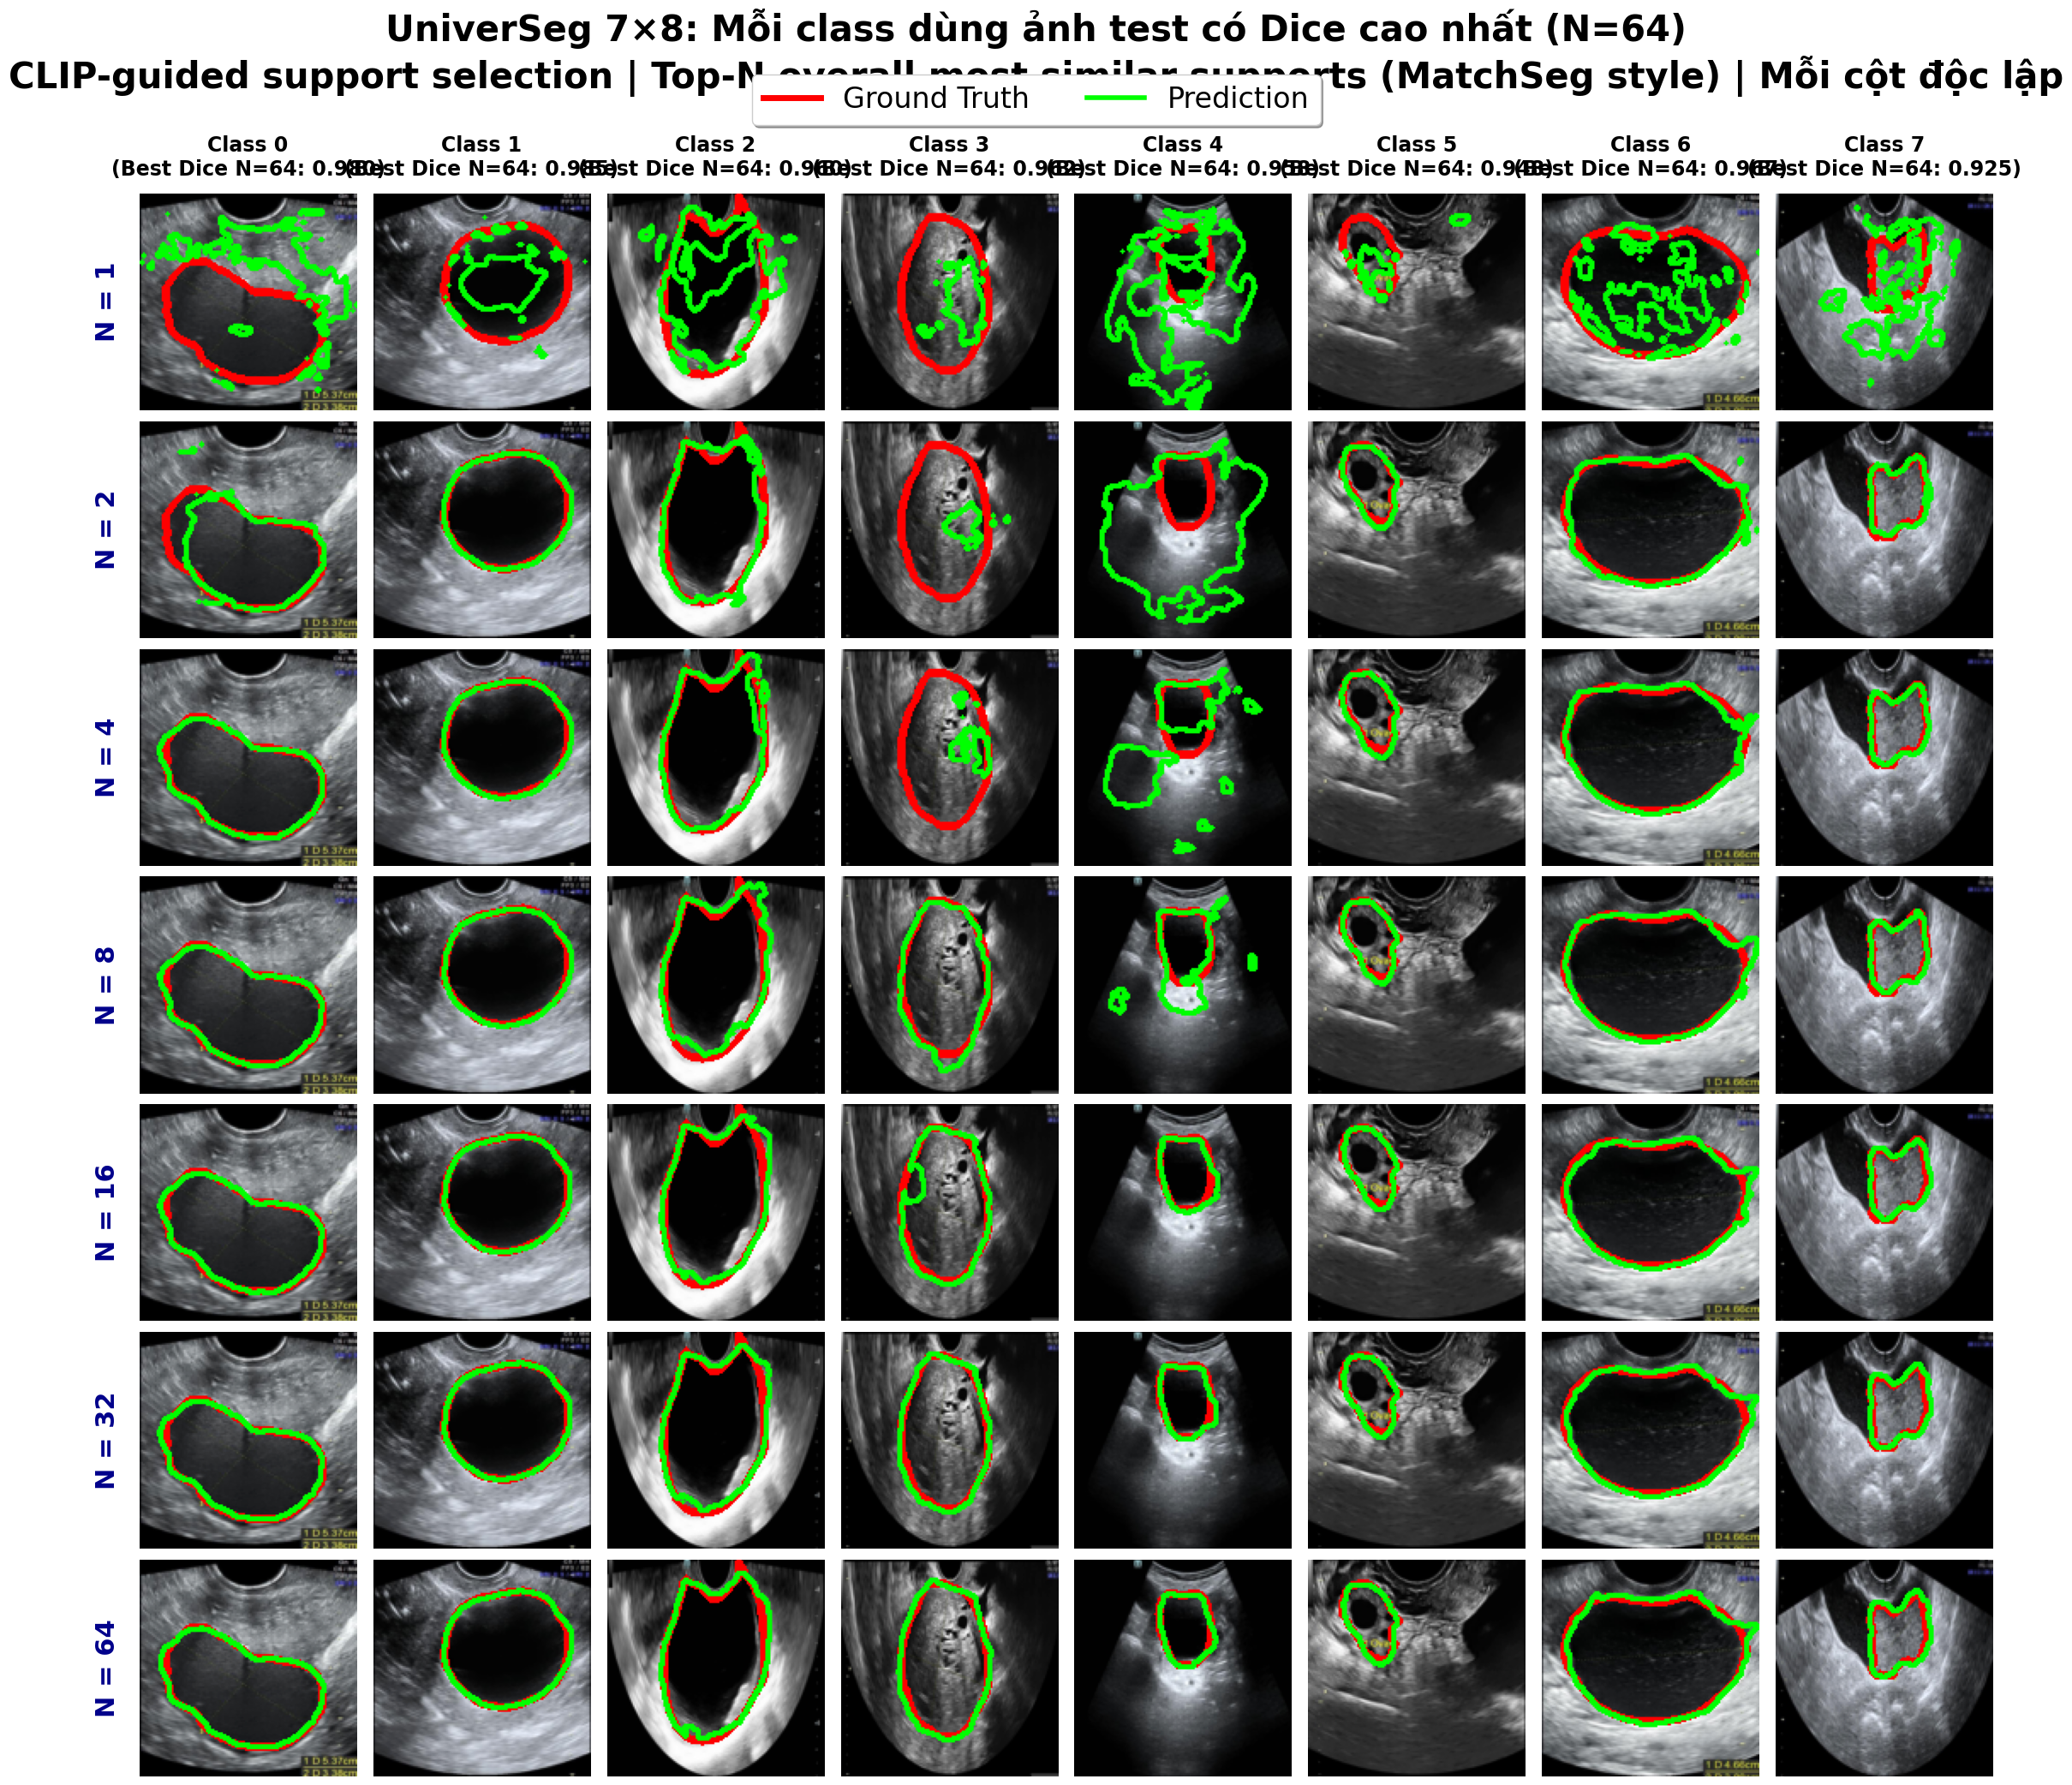

In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from universeg import universeg
from matplotlib.lines import Line2D
from PIL import Image
import clip  # pip install git+https://github.com/openai/CLIP.git

# ================== CONFIG ==================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_LIST = [1, 2, 4, 8, 16, 32, 64]
ALL_LABELS = range(NUM_CLASSES)
K_ENSEMBLE = 1  # CLIP deterministic → không cần ensemble nhiều
THRESHOLD = 0.45
N_EVAL = 64                    # Dùng N lớn để chọn ảnh tốt nhất cho mỗi class
SEARCH_NUM = min(100, len(test_set))  # Tìm trong nhiều ảnh test

# Load model
model = universeg(pretrained=True).to(DEVICE)
model.eval()

# Load CLIP
clip_model, clip_preprocess = clip.load("ViT-B/16", device=DEVICE)

# ================== HELPER ==================
def dice_score(pred, gt, threshold=THRESHOLD, smooth=1e-6):
    pred_bin = (pred > threshold).float()
    intersection = (pred_bin * gt).sum()
    union = pred_bin.sum() + gt.sum()
    return (2. * intersection + smooth) / (union + smooth)

def get_clip_emb(img_tensor):
    # img_tensor: [3, H, W], giá trị 0-1
    img_np = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
    pil_img = Image.fromarray(img_np)
    image_input = clip_preprocess(pil_img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        emb = clip_model.encode_image(image_input)
    return emb / emb.norm(p=2, dim=-1, keepdim=True)

# Precompute CLIP embeddings cho toàn bộ support_pool
print("Precomputing CLIP embeddings cho support_pool...")
support_embs = torch.cat([get_clip_emb(s[0]) for s in support_pool], dim=0)

# ================== CLIP-guided selection theo tinh thần MatchSeg ==================
def clip_support_selection_class(query_img, target_label, n_total):
    """
    Class-aware CLIP-guided support selection (UniVerSeg-safe)

    - N = n_total là N danh nghĩa (chung)
    - Effective support K = min(N, số mẫu của class)
    - CLIP chỉ dùng để xếp hạng trong pool của class
    """

    # CLIP embedding của query
    query_gray = query_img.mean(dim=0, keepdim=True).repeat(3,1,1)
    query_emb = get_clip_emb(query_gray)


    # Pool support của class target
    target_pool = label_indices_support[target_label]
    num_cls = len(target_pool)

    # Nếu class không có sample → fallback random (hiếm)
    if num_cls == 0:
        final_idxs = np.random.choice(
            range(len(support_pool)),
            size=min(n_total, len(support_pool)),
            replace=False
        ).tolist()
    else:
        # Effective support size
        K = min(n_total, num_cls)

        # Lấy embedding CLIP của class target
        cls_embs = support_embs[target_pool]      # [num_cls, D]

        # Similarity query – support (trong class)
        sims = (query_emb @ cls_embs.T)[0].cpu().numpy()  # [num_cls]

        # Top-K similar nhất
        topk_idx = np.argsort(-sims)[:K]
        final_idxs = [target_pool[i] for i in topk_idx]

    # Lấy ảnh & mask
    imgs = [support_pool[i][0].mean(dim=0, keepdim=True) for i in final_idxs]
    masks = [support_pool[i][1][target_label].unsqueeze(0) for i in final_idxs]

    support_imgs = torch.stack(imgs).unsqueeze(0).to(DEVICE)    # [1, K, 1, H, W]
    support_masks = torch.stack(masks).unsqueeze(0).to(DEVICE)  # [1, K, 1, H, W]

    return support_imgs, support_masks

# ================== TÌM ẢNH TỐT NHẤT CHO TỪNG CLASS ==================
print(f"Đang tìm ảnh test có Dice cao nhất cho từng class (trong {SEARCH_NUM} ảnh đầu)...")

best_image_per_class = {}  # label_idx -> (best_dice, idx, filename)

for label_idx in ALL_LABELS:
    best_dice = -1
    best_idx = None
    best_name = None

    for idx in range(SEARCH_NUM):
        query_img, query_gt, img_path = test_set[idx]
        if query_gt[label_idx].sum() <= 10:  # Bỏ qua nếu ít pixel positive
            continue

        query_img_dev = query_img.to(DEVICE)
        query_gray = query_img_dev.mean(dim=0, keepdim=True).unsqueeze(0)

        preds = []
        for _ in range(K_ENSEMBLE):
            sup_imgs, sup_masks = clip_support_selection_class(query_img, label_idx, N_EVAL)
            with torch.no_grad():
                prob = torch.sigmoid(model(query_gray, sup_imgs, sup_masks)[0, 0])
                preds.append(prob)
        avg_pred = torch.mean(torch.stack(preds), dim=0)
        d = dice_score(avg_pred, query_gt[label_idx].to(DEVICE)).item()

        if d > best_dice:
            best_dice = d
            best_idx = idx
            best_name = os.path.basename(img_path)

    if best_idx is not None:
        best_image_per_class[label_idx] = (best_dice, best_idx, best_name)
        print(f"  → {LABEL_NAMES[label_idx]:25} : Best Dice = {best_dice:.3f} | Ảnh: {best_name} (idx={best_idx})")

# ================== INFERENCE VÀ VẼ BẢNG 7x8 ==================
print("\nĐang chạy inference đầy đủ cho bảng 7x8 (mỗi class dùng ảnh riêng)...")

predictions = {}  # (label_idx, N) -> pred_numpy
rgb_cache = {}    # label_idx -> rgb_uint8
gt_cache = {}     # label_idx -> gt_channel_cpu

for label_idx, (_, best_idx, _) in best_image_per_class.items():
    query_img, query_gt, _ = test_set[best_idx]
    query_img_dev = query_img.to(DEVICE)
    query_gray = query_img_dev.mean(dim=0, keepdim=True).unsqueeze(0)

    # Cache RGB và GT
    rgb_float = query_img_dev.permute(1, 2, 0).cpu().numpy()
    rgb_float = (rgb_float - rgb_float.min()) / (rgb_float.max() - rgb_float.min() + 1e-8)
    rgb_cache[label_idx] = (rgb_float * 255).astype(np.uint8)
    gt_cache[label_idx] = query_gt[label_idx].cpu()

    # Inference cho từng N
    for N in N_LIST:
        preds = []
        for _ in range(K_ENSEMBLE):
            sup_imgs, sup_masks = clip_support_selection_class(query_img, label_idx, N)
            with torch.no_grad():
                prob = torch.sigmoid(model(query_gray, sup_imgs, sup_masks)[0, 0]).cpu().numpy()
                preds.append(prob)
        predictions[(label_idx, N)] = np.mean(preds, axis=0)

# ================== VẼ BẢNG 7x8 ==================
fig = plt.figure(figsize=(28, 24))
gs = fig.add_gridspec(len(N_LIST), NUM_CLASSES, hspace=0.05, wspace=0.05)

for row, N in enumerate(N_LIST):
    for col, label_idx in enumerate(ALL_LABELS):
        ax = fig.add_subplot(gs[row, col])

        if label_idx not in rgb_cache:
            ax.text(0.5, 0.5, 'No image', ha='center', va='center', fontsize=16, color='gray', transform=ax.transAxes)
            ax.axis('off')
            continue

        vis = rgb_cache[label_idx].copy()

        # Ground Truth: đỏ, dày
        gt_mask = (gt_cache[label_idx].numpy() > 0.5).astype(np.uint8) * 255
        contours_gt, _ = cv2.findContours(gt_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(vis, contours_gt, -1, (255, 0, 0), thickness=4)

        # Prediction: xanh lá, mỏng
        pred = predictions[(label_idx, N)]
        pred_bin = (pred > THRESHOLD).astype(np.uint8) * 255
        contours_pred, _ = cv2.findContours(pred_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(vis, contours_pred, -1, (0, 255, 0), thickness=2)

        ax.imshow(vis)
        ax.axis('off')

        if row == 0:
            dice_N64 = best_image_per_class[label_idx][0]
            ax.set_title(f"{LABEL_NAMES[label_idx]}\n(Best Dice N=64: {dice_N64:.3f})",
                         fontsize=17, fontweight='bold', pad=15)
        if col == 0:
            ax.text(-0.15, 0.5, f"N = {N}", transform=ax.transAxes, fontsize=22,
                    rotation=90, va='center', ha='center', fontweight='bold', color='darkblue')

# Legend & Title
legend_elements = [
    Line2D([0], [0], color='red', lw=5, label='Ground Truth'),
    Line2D([0], [0], color='lime', lw=4, label='Prediction')
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.945),
           ncol=2, fontsize=24, frameon=True, fancybox=True, shadow=True)

fig.suptitle("UniverSeg 7×8: Mỗi class dùng ảnh test có Dice cao nhất (N=64)\n"
             "CLIP-guided support selection | Top-N overall most similar supports (MatchSeg style) | Mỗi cột độc lập",
             fontsize=30, y=0.97, fontweight='bold')

save_path = "UniverSeg_7x8_per_class_best_image_CLIP_MatchSeg_style.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\nHOÀN TẤT! Bảng đã lưu tại: {save_path}")
plt.show()

ĐÁNH GIÁ METRICS TRUNG BÌNH THEO SỐ LƯỢNG SUPPORT (N)

Đang đánh giá trên 469 ảnh test...


Evaluating: 100%|██████████| 469/469 [02:09<00:00,  3.62it/s]



KẾT QUẢ TRUNG BÌNH THEO N:

   N |         Dice |          IoU |    Precision |       Recall
------------------------------------------------------------
   1 | 0.3947±0.224 | 0.2716±0.187 | 0.4651±0.287 | 0.4309±0.261
   2 | 0.5677±0.284 | 0.4506±0.278 | 0.6028±0.310 | 0.6159±0.308
   4 | 0.6562±0.268 | 0.5429±0.279 | 0.6648±0.292 | 0.7206±0.278
   8 | 0.6987±0.259 | 0.5905±0.274 | 0.6919±0.284 | 0.7729±0.261
  16 | 0.7262±0.246 | 0.6211±0.268 | 0.7151±0.275 | 0.8091±0.235
  32 | 0.7434±0.244 | 0.6428±0.268 | 0.7292±0.273 | 0.8342±0.224
  64 | 0.7523±0.242 | 0.6539±0.267 | 0.7377±0.272 | 0.8438±0.217


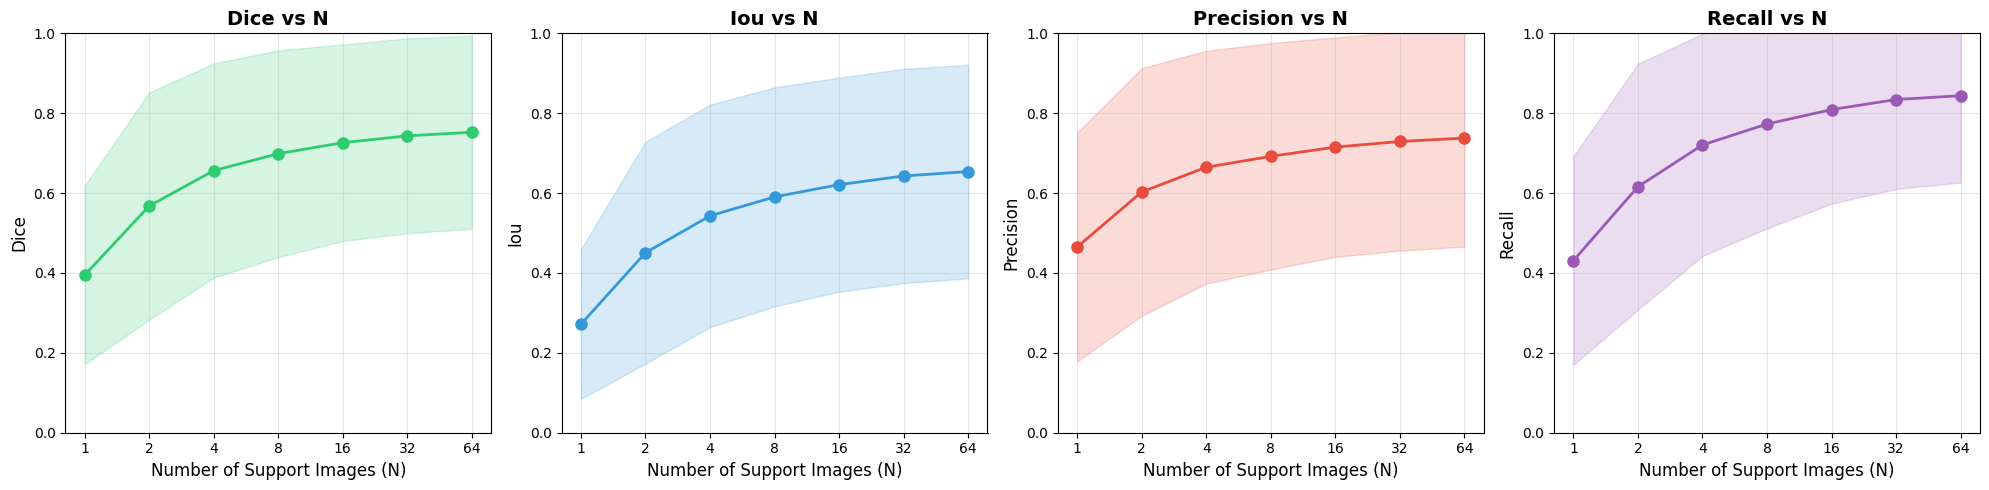


✅ Đã lưu kết quả vào: metrics_by_N.csv và metrics_by_N.png


In [8]:
# ================== TÍNH METRICS TRUNG BÌNH THEO N ==================
import pandas as pd
from tqdm import tqdm

def compute_metrics(pred, gt, threshold=THRESHOLD):
    """Tính Dice, IoU, Precision, Recall"""
    pred_bin = (pred > threshold).float()
    
    TP = (pred_bin * gt).sum()
    FP = (pred_bin * (1 - gt)).sum()
    FN = ((1 - pred_bin) * gt).sum()
    
    # Dice = 2TP / (2TP + FP + FN)
    dice = (2 * TP + 1e-6) / (2 * TP + FP + FN + 1e-6)
    
    # IoU = TP / (TP + FP + FN)
    iou = (TP + 1e-6) / (TP + FP + FN + 1e-6)
    
    # Precision = TP / (TP + FP)
    precision = (TP + 1e-6) / (TP + FP + 1e-6)
    
    # Recall = TP / (TP + FN)
    recall = (TP + 1e-6) / (TP + FN + 1e-6)
    
    return {
        'dice': dice.item(),
        'iou': iou.item(),
        'precision': precision.item(),
        'recall': recall.item()
    }

# ================== ĐÁNH GIÁ TRÊN TOÀN BỘ TEST SET ==================
print("=" * 80)
print("ĐÁNH GIÁ METRICS TRUNG BÌNH THEO SỐ LƯỢNG SUPPORT (N)")
print("=" * 80)

N_LIST_EVAL = [1, 2, 4, 8, 16, 32, 64]
NUM_TEST_SAMPLES = min(496, len(test_set))  # Giới hạn số ảnh test để tính nhanh

results_by_N = {N: {'dice': [], 'iou': [], 'precision': [], 'recall': []} for N in N_LIST_EVAL}

print(f"\nĐang đánh giá trên {NUM_TEST_SAMPLES} ảnh test...")

for idx in tqdm(range(NUM_TEST_SAMPLES), desc="Evaluating"):
    query_img, query_gt, img_path = test_set[idx]
    
    # Tìm class có mask
    active_class = None
    for c in range(NUM_CLASSES):
        if query_gt[c].sum() > 10:
            active_class = c
            break
    
    if active_class is None:
        continue
    
    query_img_dev = query_img.to(DEVICE)
    query_gray = query_img_dev.mean(dim=0, keepdim=True).unsqueeze(0)
    gt = query_gt[active_class].to(DEVICE)
    
    for N in N_LIST_EVAL:
        sup_imgs, sup_masks = clip_support_selection_class(query_img, active_class, N)
        
        with torch.no_grad():
            pred = torch.sigmoid(model(query_gray, sup_imgs, sup_masks)[0, 0])
        
        metrics = compute_metrics(pred, gt)
        for key in metrics:
            results_by_N[N][key].append(metrics[key])

# Tính trung bình
avg_results = []
for N in N_LIST_EVAL:
    row = {'N': N}
    for metric in ['dice', 'iou', 'precision', 'recall']:
        values = results_by_N[N][metric]
        row[metric] = np.mean(values) if values else 0
        row[f'{metric}_std'] = np.std(values) if values else 0
    avg_results.append(row)

df_avg = pd.DataFrame(avg_results)

# Hiển thị bảng
print("\n" + "=" * 80)
print("KẾT QUẢ TRUNG BÌNH THEO N:")
print("=" * 80)
print(f"\n{'N':>4} | {'Dice':>12} | {'IoU':>12} | {'Precision':>12} | {'Recall':>12}")
print("-" * 60)
for _, row in df_avg.iterrows():
    print(f"{int(row['N']):>4} | {row['dice']:.4f}±{row['dice_std']:.3f} | {row['iou']:.4f}±{row['iou_std']:.3f} | {row['precision']:.4f}±{row['precision_std']:.3f} | {row['recall']:.4f}±{row['recall_std']:.3f}")

# Vẽ biểu đồ
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
metrics_names = ['dice', 'iou', 'precision', 'recall']
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']

for ax, metric, color in zip(axes, metrics_names, colors):
    means = df_avg[metric].values
    stds = df_avg[f'{metric}_std'].values
    
    ax.plot(N_LIST_EVAL, means, 'o-', color=color, linewidth=2, markersize=8)
    ax.fill_between(N_LIST_EVAL, means - stds, means + stds, alpha=0.2, color=color)
    ax.set_xlabel('Number of Support Images (N)', fontsize=12)
    ax.set_ylabel(metric.capitalize(), fontsize=12)
    ax.set_title(f'{metric.capitalize()} vs N', fontsize=14, fontweight='bold')
    ax.set_xscale('log', base=2)
    ax.set_xticks(N_LIST_EVAL)
    ax.set_xticklabels(N_LIST_EVAL)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('metrics_by_N.png', dpi=200, bbox_inches='tight')
plt.show()

# Lưu CSV
df_avg.to_csv('metrics_by_N.csv', index=False)
print(f"\n✅ Đã lưu kết quả vào: metrics_by_N.csv và metrics_by_N.png")

ĐÁNH GIÁ UNIVERSEG GỐC (RANDOM SELECTION - KHÔNG DÙNG CLIP)

Đang đánh giá trên 469 ảnh test (Random selection, 3 runs)...

--- Run 1/3 ---


Evaluating Run 1: 100%|██████████| 469/469 [01:53<00:00,  4.15it/s]



--- Run 2/3 ---


Evaluating Run 2: 100%|██████████| 469/469 [01:52<00:00,  4.17it/s]



--- Run 3/3 ---


Evaluating Run 3: 100%|██████████| 469/469 [01:52<00:00,  4.17it/s]



KẾT QUẢ UNIVERSEG GỐC (RANDOM SELECTION):

   N |         Dice |          IoU |    Precision |       Recall
------------------------------------------------------------
   1 | 0.3241±0.189 | 0.2091±0.141 | 0.3969±0.275 | 0.3764±0.243
   2 | 0.4566±0.259 | 0.3331±0.225 | 0.5161±0.311 | 0.5170±0.300
   4 | 0.5572±0.274 | 0.4349±0.261 | 0.5898±0.310 | 0.6285±0.301
   8 | 0.6219±0.274 | 0.5052±0.276 | 0.6218±0.304 | 0.7189±0.277
  16 | 0.6695±0.263 | 0.5563±0.274 | 0.6595±0.292 | 0.7722±0.250
  32 | 0.7053±0.257 | 0.5984±0.274 | 0.6935±0.285 | 0.8047±0.240
  64 | 0.7292±0.250 | 0.6263±0.271 | 0.7192±0.279 | 0.8233±0.229

SO SÁNH: CLIP-GUIDED vs RANDOM SELECTION

   N |    CLIP Dice |  Random Dice |     Δ Dice |   CLIP IoU | Random IoU |    Δ IoU
------------------------------------------------------------------------------------------
   1 | 0.3947       | 0.3241        |    +0.0706 | 0.2716     | 0.2091      |  +0.0625
   2 | 0.5677       | 0.4566        |    +0.1111 | 0.4506     | 0.333

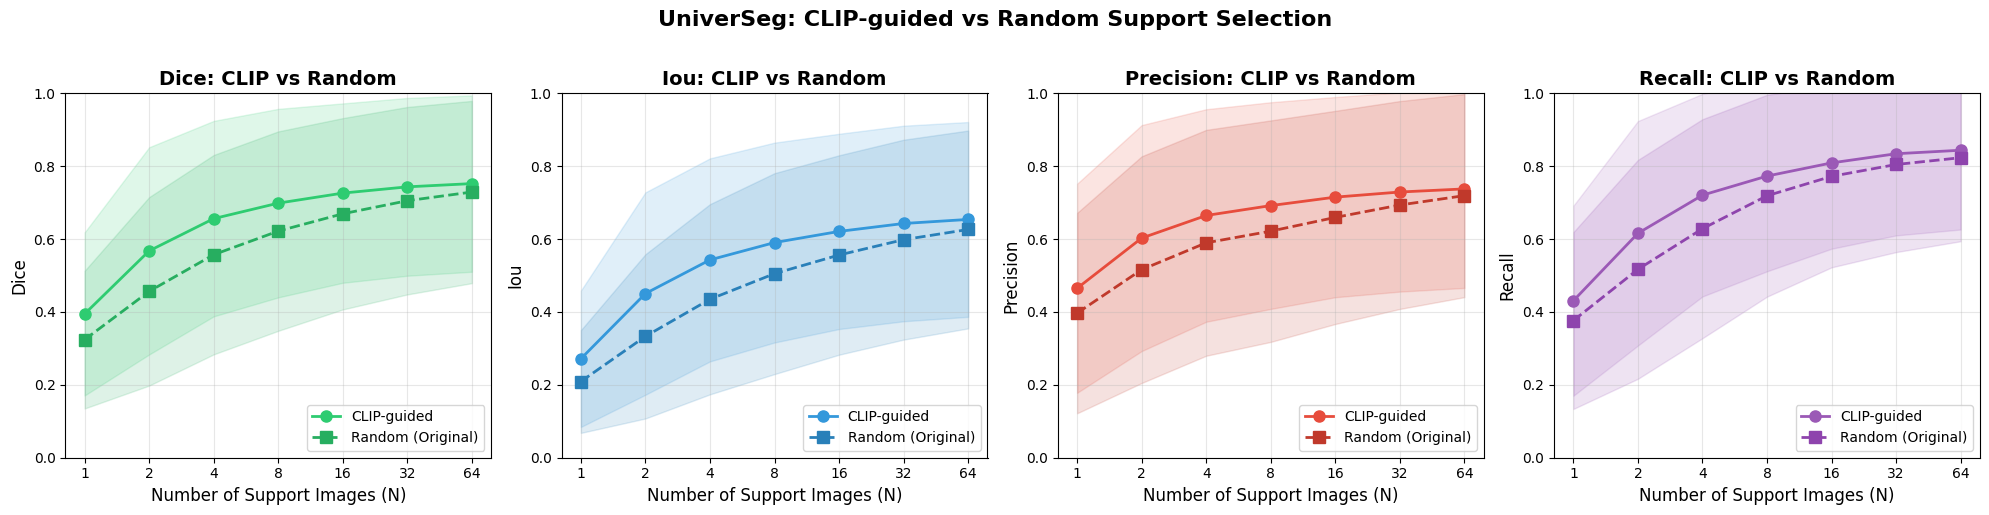


✅ Đã lưu kết quả Random vào: metrics_by_N_random.csv và metrics_CLIP_vs_Random.png

📊 TỔNG KẾT SO SÁNH (tại N=32):
   CLIP-guided:
   ├─ Dice:      0.7434
   ├─ IoU:       0.6428
   ├─ Precision: 0.7292
   └─ Recall:    0.8342

   Random (Original UniverSeg):
   ├─ Dice:      0.7053
   ├─ IoU:       0.5984
   ├─ Precision: 0.6935
   └─ Recall:    0.8047

   Improvement (CLIP - Random):
   ├─ Δ Dice: +0.0380
   └─ Δ IoU:  +0.0444


In [9]:
# ================== TÍNH METRICS CHO UNIVERSEG GỐC (RANDOM SELECTION - KHÔNG DÙNG CLIP) ==================
import pandas as pd
from tqdm import tqdm
import random

def random_support_selection_class(target_label, n_total):
    """
    Random support selection (UniverSeg gốc - không dùng CLIP)
    - Chọn ngẫu nhiên N support images từ pool của class target
    """
    # Pool support của class target
    target_pool = label_indices_support[target_label]
    num_cls = len(target_pool)
    
    # Nếu class không có sample → fallback random từ toàn bộ pool
    if num_cls == 0:
        final_idxs = random.sample(range(len(support_pool)), min(n_total, len(support_pool)))
    else:
        # Effective support size
        K = min(n_total, num_cls)
        # Chọn ngẫu nhiên K samples
        final_idxs = random.sample(target_pool, K)
    
    # Lấy ảnh & mask
    imgs = [support_pool[i][0].mean(dim=0, keepdim=True) for i in final_idxs]
    masks = [support_pool[i][1][target_label].unsqueeze(0) for i in final_idxs]
    
    support_imgs = torch.stack(imgs).unsqueeze(0).to(DEVICE)    # [1, K, 1, H, W]
    support_masks = torch.stack(masks).unsqueeze(0).to(DEVICE)  # [1, K, 1, H, W]
    
    return support_imgs, support_masks

# ================== ĐÁNH GIÁ UNIVERSEG GỐC (RANDOM) ==================
print("=" * 80)
print("ĐÁNH GIÁ UNIVERSEG GỐC (RANDOM SELECTION - KHÔNG DÙNG CLIP)")
print("=" * 80)

N_LIST_EVAL = [1, 2, 4, 8, 16, 32, 64]
NUM_TEST_SAMPLES = min(496, len(test_set))
NUM_RUNS = 3  # Chạy nhiều lần để lấy trung bình vì random

results_by_N_random = {N: {'dice': [], 'iou': [], 'precision': [], 'recall': []} for N in N_LIST_EVAL}

print(f"\nĐang đánh giá trên {NUM_TEST_SAMPLES} ảnh test (Random selection, {NUM_RUNS} runs)...")

for run in range(NUM_RUNS):
    print(f"\n--- Run {run + 1}/{NUM_RUNS} ---")
    for idx in tqdm(range(NUM_TEST_SAMPLES), desc=f"Evaluating Run {run+1}"):
        query_img, query_gt, img_path = test_set[idx]
        
        # Tìm class có mask
        active_class = None
        for c in range(NUM_CLASSES):
            if query_gt[c].sum() > 10:
                active_class = c
                break
        
        if active_class is None:
            continue
        
        query_img_dev = query_img.to(DEVICE)
        query_gray = query_img_dev.mean(dim=0, keepdim=True).unsqueeze(0)
        gt = query_gt[active_class].to(DEVICE)
        
        for N in N_LIST_EVAL:
            sup_imgs, sup_masks = random_support_selection_class(active_class, N)
            
            with torch.no_grad():
                pred = torch.sigmoid(model(query_gray, sup_imgs, sup_masks)[0, 0])
            
            metrics = compute_metrics(pred, gt)
            for key in metrics:
                results_by_N_random[N][key].append(metrics[key])

# Tính trung bình
avg_results_random = []
for N in N_LIST_EVAL:
    row = {'N': N}
    for metric in ['dice', 'iou', 'precision', 'recall']:
        values = results_by_N_random[N][metric]
        row[metric] = np.mean(values) if values else 0
        row[f'{metric}_std'] = np.std(values) if values else 0
    avg_results_random.append(row)

df_avg_random = pd.DataFrame(avg_results_random)

# Hiển thị bảng
print("\n" + "=" * 80)
print("KẾT QUẢ UNIVERSEG GỐC (RANDOM SELECTION):")
print("=" * 80)
print(f"\n{'N':>4} | {'Dice':>12} | {'IoU':>12} | {'Precision':>12} | {'Recall':>12}")
print("-" * 60)
for _, row in df_avg_random.iterrows():
    print(f"{int(row['N']):>4} | {row['dice']:.4f}±{row['dice_std']:.3f} | {row['iou']:.4f}±{row['iou_std']:.3f} | {row['precision']:.4f}±{row['precision_std']:.3f} | {row['recall']:.4f}±{row['recall_std']:.3f}")

# ================== SO SÁNH CLIP vs RANDOM ==================
print("\n" + "=" * 80)
print("SO SÁNH: CLIP-GUIDED vs RANDOM SELECTION")
print("=" * 80)
print(f"\n{'N':>4} | {'CLIP Dice':>12} | {'Random Dice':>12} | {'Δ Dice':>10} | {'CLIP IoU':>10} | {'Random IoU':>10} | {'Δ IoU':>8}")
print("-" * 90)

for i, N in enumerate(N_LIST_EVAL):
    clip_dice = df_avg.iloc[i]['dice']
    rand_dice = df_avg_random.iloc[i]['dice']
    delta_dice = clip_dice - rand_dice
    
    clip_iou = df_avg.iloc[i]['iou']
    rand_iou = df_avg_random.iloc[i]['iou']
    delta_iou = clip_iou - rand_iou
    
    delta_str_dice = f"+{delta_dice:.4f}" if delta_dice > 0 else f"{delta_dice:.4f}"
    delta_str_iou = f"+{delta_iou:.4f}" if delta_iou > 0 else f"{delta_iou:.4f}"
    
    print(f"{N:>4} | {clip_dice:.4f}       | {rand_dice:.4f}        | {delta_str_dice:>10} | {clip_iou:.4f}     | {rand_iou:.4f}      | {delta_str_iou:>8}")

# Vẽ biểu đồ so sánh
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
metrics_names = ['dice', 'iou', 'precision', 'recall']
colors_clip = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']
colors_random = ['#27ae60', '#2980b9', '#c0392b', '#8e44ad']

for ax, metric, c_clip, c_rand in zip(axes, metrics_names, colors_clip, colors_random):
    means_clip = df_avg[metric].values
    stds_clip = df_avg[f'{metric}_std'].values
    means_random = df_avg_random[metric].values
    stds_random = df_avg_random[f'{metric}_std'].values
    
    ax.plot(N_LIST_EVAL, means_clip, 'o-', color=c_clip, linewidth=2, markersize=8, label='CLIP-guided')
    ax.fill_between(N_LIST_EVAL, means_clip - stds_clip, means_clip + stds_clip, alpha=0.15, color=c_clip)
    
    ax.plot(N_LIST_EVAL, means_random, 's--', color=c_rand, linewidth=2, markersize=8, label='Random (Original)')
    ax.fill_between(N_LIST_EVAL, means_random - stds_random, means_random + stds_random, alpha=0.15, color=c_rand)
    
    ax.set_xlabel('Number of Support Images (N)', fontsize=12)
    ax.set_ylabel(metric.capitalize(), fontsize=12)
    ax.set_title(f'{metric.capitalize()}: CLIP vs Random', fontsize=14, fontweight='bold')
    ax.set_xscale('log', base=2)
    ax.set_xticks(N_LIST_EVAL)
    ax.set_xticklabels(N_LIST_EVAL)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)
    ax.legend(loc='lower right')

plt.suptitle('UniverSeg: CLIP-guided vs Random Support Selection', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('metrics_CLIP_vs_Random.png', dpi=200, bbox_inches='tight')
plt.show()

# Lưu CSV
df_avg_random.to_csv('metrics_by_N_random.csv', index=False)
print(f"\n✅ Đã lưu kết quả Random vào: metrics_by_N_random.csv và metrics_CLIP_vs_Random.png")

# Tổng kết
print("\n" + "=" * 50)
print("📊 TỔNG KẾT SO SÁNH (tại N=32):")
print("=" * 50)
n32_idx = N_LIST_EVAL.index(32)
print(f"   CLIP-guided:")
print(f"   ├─ Dice:      {df_avg.iloc[n32_idx]['dice']:.4f}")
print(f"   ├─ IoU:       {df_avg.iloc[n32_idx]['iou']:.4f}")
print(f"   ├─ Precision: {df_avg.iloc[n32_idx]['precision']:.4f}")
print(f"   └─ Recall:    {df_avg.iloc[n32_idx]['recall']:.4f}")
print(f"\n   Random (Original UniverSeg):")
print(f"   ├─ Dice:      {df_avg_random.iloc[n32_idx]['dice']:.4f}")
print(f"   ├─ IoU:       {df_avg_random.iloc[n32_idx]['iou']:.4f}")
print(f"   ├─ Precision: {df_avg_random.iloc[n32_idx]['precision']:.4f}")
print(f"   └─ Recall:    {df_avg_random.iloc[n32_idx]['recall']:.4f}")
print(f"\n   Improvement (CLIP - Random):")
delta_dice = df_avg.iloc[n32_idx]['dice'] - df_avg_random.iloc[n32_idx]['dice']
delta_iou = df_avg.iloc[n32_idx]['iou'] - df_avg_random.iloc[n32_idx]['iou']
print(f"   ├─ Δ Dice: {'+' if delta_dice > 0 else ''}{delta_dice:.4f}")
print(f"   └─ Δ IoU:  {'+' if delta_iou > 0 else ''}{delta_iou:.4f}")

ĐÁNH GIÁ METRICS CHO TỪNG CLASS TẠI N = 64

Đang đánh giá với N = 64...


Evaluating: 100%|██████████| 469/469 [00:53<00:00,  8.73it/s]



KẾT QUẢ METRICS CHO TỪNG CLASS (N = 64):

 Class |         Name | #Samples |           Dice |            IoU |      Precision |         Recall
----------------------------------------------------------------------------------------------------
     0 |      Class 0 |      110 | 0.7751±0.233 | 0.6819±0.262 | 0.7481±0.272 | 0.8784±0.185
     1 |      Class 1 |       66 | 0.8927±0.115 | 0.8222±0.156 | 0.8789±0.157 | 0.9318±0.078
     2 |      Class 2 |      108 | 0.7699±0.178 | 0.6562±0.213 | 0.7394±0.232 | 0.8623±0.162
     3 |      Class 3 |       31 | 0.8149±0.182 | 0.7205±0.216 | 0.7648±0.219 | 0.9129±0.112
     4 |      Class 4 |       19 | 0.7998±0.219 | 0.7106±0.247 | 0.7901±0.263 | 0.8630±0.139
     5 |      Class 5 |       87 | 0.5015±0.280 | 0.3833±0.264 | 0.5440±0.339 | 0.6429±0.323
     6 |      Class 6 |       33 | 0.9037±0.086 | 0.8346±0.131 | 0.8783±0.122 | 0.9422±0.074
     7 |      Class 7 |       15 | 0.7719±0.161 | 0.6552±0.204 | 0.7197±0.163 | 0.8528±0.183
-----------

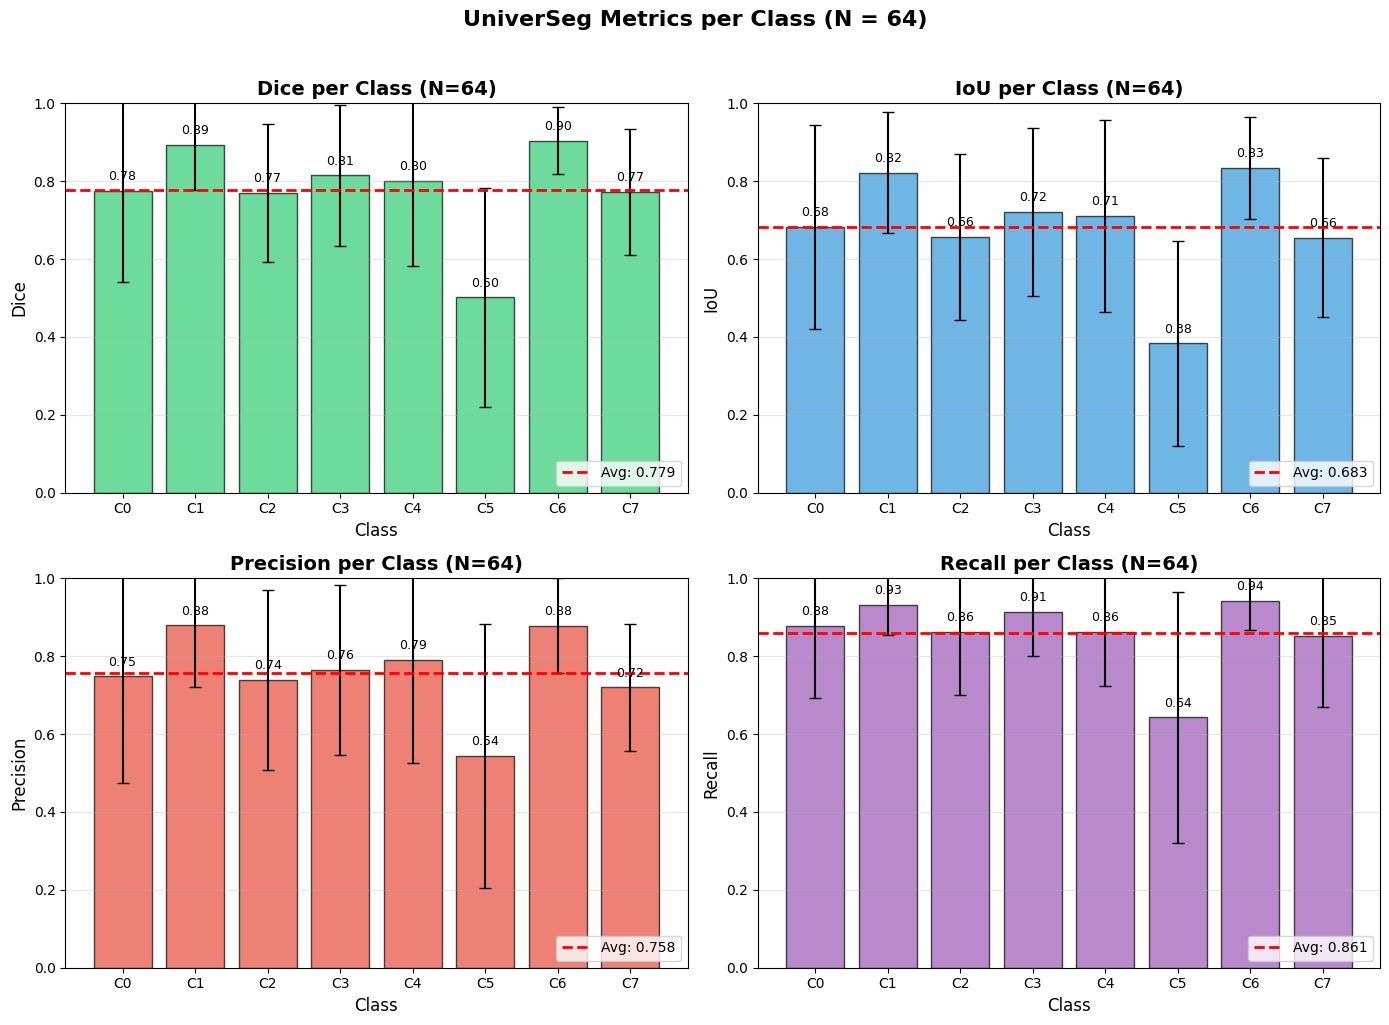


✅ Đã lưu kết quả vào: metrics_per_class_N64.csv và metrics_per_class_N64.png

📊 TỔNG KẾT:
   N = 64
   Số class được đánh giá: 8
   Tổng số samples: 469
   
   TRUNG BÌNH:
   ├─ Dice:      0.7787
   ├─ IoU:       0.6831
   ├─ Precision: 0.7579
   └─ Recall:    0.8608

   🏆 Best class:  Class 6 (Dice=0.9037)
   ⚠️  Worst class: Class 5 (Dice=0.5015)


In [ ]:
# ================== TÍNH METRICS CHO TỪNG CLASS TẠI N TÙY CHỌN ==================

# ============ CẤU HÌNH ============
N_SELECTED = 64  # ← THAY ĐỔI GIÁ TRỊ N TẠI ĐÂY
NUM_SAMPLES_PER_CLASS = 50  # Số ảnh tối đa để đánh giá mỗi class
# ==================================

print("=" * 80)
print(f"ĐÁNH GIÁ METRICS CHO TỪNG CLASS TẠI N = {N_SELECTED}")
print("=" * 80)

# Thu thập metrics cho từng class
class_metrics = {c: {'dice': [], 'iou': [], 'precision': [], 'recall': [], 'count': 0} 
                 for c in range(NUM_CLASSES)}

print(f"\nĐang đánh giá với N = {N_SELECTED}...")

for idx in tqdm(range(len(test_set)), desc="Evaluating"):
    query_img, query_gt, img_path = test_set[idx]
    
    for cls_idx in range(NUM_CLASSES):
        if query_gt[cls_idx].sum() <= 10:
            continue
        
        # Giới hạn số samples mỗi class
        if class_metrics[cls_idx]['count'] >= NUM_SAMPLES_PER_CLASS:
            continue
        
        query_img_dev = query_img.to(DEVICE)
        query_gray = query_img_dev.mean(dim=0, keepdim=True).unsqueeze(0)
        gt = query_gt[cls_idx].to(DEVICE)
        
        sup_imgs, sup_masks = clip_support_selection_class(query_img, cls_idx, N_SELECTED)
        
        with torch.no_grad():
            pred = torch.sigmoid(model(query_gray, sup_imgs, sup_masks)[0, 0])
        
        metrics = compute_metrics(pred, gt)
        for key in metrics:
            class_metrics[cls_idx][key].append(metrics[key])
        class_metrics[cls_idx]['count'] += 1

# Tạo DataFrame kết quả
results_per_class = []
for cls_idx in range(NUM_CLASSES):
    if class_metrics[cls_idx]['count'] == 0:
        continue
    
    row = {
        'Class': cls_idx,
        'Name': LABEL_NAMES[cls_idx],
        'Samples': class_metrics[cls_idx]['count'],
        'Dice': np.mean(class_metrics[cls_idx]['dice']),
        'Dice_std': np.std(class_metrics[cls_idx]['dice']),
        'IoU': np.mean(class_metrics[cls_idx]['iou']),
        'IoU_std': np.std(class_metrics[cls_idx]['iou']),
        'Precision': np.mean(class_metrics[cls_idx]['precision']),
        'Precision_std': np.std(class_metrics[cls_idx]['precision']),
        'Recall': np.mean(class_metrics[cls_idx]['recall']),
        'Recall_std': np.std(class_metrics[cls_idx]['recall']),
    }
    results_per_class.append(row)

df_class = pd.DataFrame(results_per_class)

# Hiển thị bảng chi tiết
print("\n" + "=" * 100)
print(f"KẾT QUẢ METRICS CHO TỪNG CLASS (N = {N_SELECTED}):")
print("=" * 100)
print(f"\n{'Class':>6} | {'Name':>12} | {'#Samples':>8} | {'Dice':>14} | {'IoU':>14} | {'Precision':>14} | {'Recall':>14}")
print("-" * 100)

for _, row in df_class.iterrows():
    print(f"{int(row['Class']):>6} | {row['Name']:>12} | {int(row['Samples']):>8} | "
          f"{row['Dice']:.4f}±{row['Dice_std']:.3f} | {row['IoU']:.4f}±{row['IoU_std']:.3f} | "
          f"{row['Precision']:.4f}±{row['Precision_std']:.3f} | {row['Recall']:.4f}±{row['Recall_std']:.3f}")

# Tính trung bình tổng
print("-" * 100)
avg_dice = df_class['Dice'].mean()
avg_iou = df_class['IoU'].mean()
avg_precision = df_class['Precision'].mean()
avg_recall = df_class['Recall'].mean()
print(f"{'AVG':>6} | {'':>12} | {'':>8} | {avg_dice:.4f}         | {avg_iou:.4f}         | {avg_precision:.4f}         | {avg_recall:.4f}")

# Vẽ biểu đồ bar chart
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics_to_plot = ['Dice', 'IoU', 'Precision', 'Recall']
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']

for ax, metric, color in zip(axes.flatten(), metrics_to_plot, colors):
    x = np.arange(len(df_class))
    means = df_class[metric].values
    stds = df_class[f'{metric}_std'].values
    
    bars = ax.bar(x, means, yerr=stds, capsize=4, color=color, alpha=0.7, edgecolor='black')
    ax.set_xticks(x)
    ax.set_xticklabels([f"C{int(c)}" for c in df_class['Class']], fontsize=10)
    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} per Class (N={N_SELECTED})', fontsize=14, fontweight='bold')
    ax.axhline(y=df_class[metric].mean(), color='red', linestyle='--', linewidth=2, label=f'Avg: {df_class[metric].mean():.3f}')
    ax.legend(loc='lower right')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Thêm giá trị lên bars
    for bar, val in zip(bars, means):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{val:.2f}', ha='center', va='bottom', fontsize=9)

plt.suptitle(f'UniverSeg Metrics per Class (N = {N_SELECTED})', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'metrics_per_class_N{N_SELECTED}.png', dpi=200, bbox_inches='tight')
plt.show()

# Lưu CSV
df_class.to_csv(f'metrics_per_class_N{N_SELECTED}.csv', index=False)
print(f"\n✅ Đã lưu kết quả vào: metrics_per_class_N{N_SELECTED}.csv và metrics_per_class_N{N_SELECTED}.png")

# Tổng kết
print("\n" + "=" * 50)
print("📊 TỔNG KẾT:")
print("=" * 50)
print(f"   N = {N_SELECTED}")
print(f"   Số class được đánh giá: {len(df_class)}")
print(f"   Tổng số samples: {df_class['Samples'].sum()}")
print(f"   \n   TRUNG BÌNH:")
print(f"   ├─ Dice:      {avg_dice:.4f}")
print(f"   ├─ IoU:       {avg_iou:.4f}")
print(f"   ├─ Precision: {avg_precision:.4f}")
print(f"   └─ Recall:    {avg_recall:.4f}")

# Best & Worst class
best_class = df_class.loc[df_class['Dice'].idxmax()]
worst_class = df_class.loc[df_class['Dice'].idxmin()]
print(f"\n   🏆 Best class:  {best_class['Name']} (Dice={best_class['Dice']:.4f})")
print(f"   ⚠️  Worst class: {worst_class['Name']} (Dice={worst_class['Dice']:.4f})")

In [ ]:
# ================== VISUALIZE ẢNH TỐT NHẤT CHO TỪNG CLASS ==================

# Danh sách ảnh tốt nhất cho từng class
best_images = {
    0: "580.JPG",
    1: "249.JPG", 
    2: "1337.JPG",
    3: "1181.JPG",
    4: "1013.JPG",
    5: "1269.JPG",
    6: "896.JPG",
    7: "1454.JPG"
}

print("=" * 80)
print("VISUALIZE ẢNH TỐT NHẤT CHO TỪNG CLASS")
print("=" * 80)

# Tạo figure với 2 hàng x 8 cột
fig, axes = plt.subplots(2, NUM_CLASSES, figsize=(28, 8))

for cls_idx in range(NUM_CLASSES):
    img_name = best_images[cls_idx]
    img_id = img_name.replace('.JPG', '')
    
    # Tìm ảnh trong test_set
    found = False
    for idx in range(len(test_set)):
        query_img, query_gt, img_path = test_set[idx]
        if os.path.basename(img_path) == img_name:
            found = True
            break
    
    if not found:
        axes[0, cls_idx].text(0.5, 0.5, f'Not found:\n{img_name}', 
                              ha='center', va='center', fontsize=10)
        axes[0, cls_idx].axis('off')
        axes[1, cls_idx].axis('off')
        continue
    
    # Chuyển đổi ảnh sang RGB
    if isinstance(query_img, torch.Tensor):
        img_rgb = query_img.permute(1, 2, 0).cpu().numpy()
    else:
        img_rgb = np.transpose(query_img, (1, 2, 0))
    img_rgb = np.clip(img_rgb, 0, 1)
    
    # Lấy ground truth mask
    gt_mask = query_gt[cls_idx]
    if isinstance(gt_mask, torch.Tensor):
        gt_mask = gt_mask.cpu().numpy()
    
    # Tính coverage
    coverage = 100.0 * np.sum(gt_mask > 0) / gt_mask.size
    
    # === HÀNG 1: Original Image ===
    axes[0, cls_idx].imshow(img_rgb)
    axes[0, cls_idx].set_title(f"{LABEL_NAMES[cls_idx]}\n{img_name}", fontsize=11, fontweight='bold')
    axes[0, cls_idx].axis('off')
    
    # === HÀNG 2: Original + GT Contour ===
    img_bgr = (img_rgb * 255).astype(np.uint8)[:, :, ::-1]
    mask_bin = (gt_mask > 0).astype(np.uint8)
    contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    img_with_contour = img_bgr.copy()
    cv2.drawContours(img_with_contour, contours, -1, (0, 255, 0), thickness=2)
    img_with_contour_rgb = img_with_contour[:, :, ::-1]
    
    axes[1, cls_idx].imshow(img_with_contour_rgb)
    axes[1, cls_idx].set_title(f"GT Contour\n{coverage:.1f}% coverage", fontsize=10)
    axes[1, cls_idx].axis('off')

plt.suptitle('Best Images per Class with Ground Truth', fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('best_images_per_class_visualization.png', dpi=200, bbox_inches='tight')
plt.show()

print(f"\n✅ Đã lưu visualization tại: best_images_per_class_visualization.png")